In [99]:
import pandas as pd
import numpy as np
import math
from math import floor
import matplotlib.pyplot  as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

torch.manual_seed(42)

# Visualize training history
#from keras.models import Sequential
#from keras.layers import Dense

pd.options.mode.chained_assignment = None 

### Model Creation

In [18]:
# Choose CPU or Cuda device (If capable GPU present).
device = 'cpu'

class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = torch.nn.Linear(50, 25) # hidden layer
        self.hidden2 = torch.nn.Linear(25, 25) # hidden layer
        self.out = torch.nn.Linear(25, 1)      # output layer

    def forward(self, x):
        z = F.relu(self.hidden1(x)) # activation function for first hidden layer
        z = F.relu(self.hidden2(z)) # activation function for second hidden layer
        z = self.out(z)        # linear output
        return z

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (hidden1): Linear(in_features=50, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=25, bias=True)
  (out): Linear(in_features=25, out_features=1, bias=True)
)


### Dataset Loading

In [19]:
dataset = pd.read_csv("Data/BTC-USD.csv")
print(dataset.shape)
dataset.head()

(1827, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000
1,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008
2,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000
3,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008
4,2016-12-25,899.651978,899.651978,862.424011,896.182983,896.182983,143664992


#### Scaling Dataset

In [20]:
scaled_data = dataset[['Open', 'High', 'Low', 'Close', 'Volume']]
scaler = MinMaxScaler(copy=False)
scaled_data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(scaled_data[['Open', 'High', 'Low', 'Close', 'Volume']])
X = scaled_data['Close']
X

0       0.000846
1       0.001299
2       0.002159
3       0.001813
4       0.001773
          ...   
1822    0.680117
1823    0.689799
1824    0.687676
1825    0.690270
1826    0.715508
Name: Close, Length: 1827, dtype: float64

In [21]:
class TimeSeriesDataset(Data.Dataset):   
    def __init__(self, data, window):
        self.data = torch.Tensor(data.values)
        self.window = window
    
    def __getitem__(self, index):
        return (self.data[index:index+self.window], self.data[index+self.window])
    
    def __len__(self):
        return self.data.__len__() - (self.window)

#### Data Preperation

In [22]:
split_ratio = 0.8
train_size = floor(X.size*split_ratio)
test_size = floor(X.size*(1-split_ratio))

train_dataset = TimeSeriesDataset(X[:train_size], 50)
test_dataset = TimeSeriesDataset(X[train_size:], 50)
    
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss() 

#### Training Function

In [63]:
def train(dataset, model, loss_fn, optimizer):
    size = len(dataset)
    tlosses = []
    model.train()
    for batch, (X, y) in enumerate(dataset):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X).squeeze(-1)
        loss = loss_fn(pred, y)
        
        tlosses.append(loss.item())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  Batch: [{current:>5d}/{size:>5d}]")
    return tlosses

#### Testing Function

In [72]:
def test(dataset, model, loss_fn):
    size = len(dataset)
    vlosses = []
    num_batches = len(dataset) - 50
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataset:
            X, y = X.to(device), y.to(device)
            pred = model(X).squeeze(-1)
            test_loss += loss_fn(pred, y).item()
            vlosses.append(test_loss)
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return vlosses

#### Training

In [ ]:
EPOCHS = 20

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    tlosses = train(train_dataset, model, loss_fn, optimizer)
    vlosses = test(test_dataset, model, loss_fn)
print("Done!")

#### Final Prediction

In [74]:
model.eval()
data = dataset['Close']
data = torch.Tensor(data[-50:].values)
output = model(data)
print(f'Predicted next-day price based on 50 previous ones: {output.item()}')

Predicted next-day price based on 50 previous ones: 36757.796875


In [106]:
t_avg_losses = []
for i in range(floor(len(tlosses) / 20)):
    t_avg_losses.append(tlosses[i*20:i*20+20])
    
v_avg_losses = []
for i in range(floor(len(vlosses) / 20)):
    v_avg_losses.append(vlosses[i*20:i*20+20])

In [117]:
len(tlosses)

1411

In [121]:
len(vlosses)

316

### Plotting

ValueError: x and y must have same first dimension, but have shapes (20,) and (70, 20)

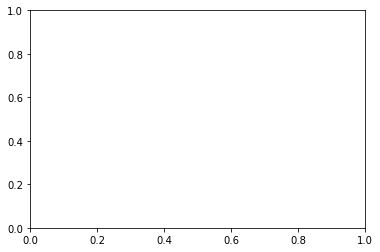

In [108]:
plt.plot(np.linspace(0, EPOCHS, EPOCHS), t_avg_losses, color="green", alpha=0.8, legend="Train loss", line_width=2)
plt.plot(np.linspace(0, EPOCHS, EPOCHS), v_avg_losses, color="red", alpha=0.8, legend="Val loss", line_width=2)